# Extended Digit Recognition – Comparative Study (MLP · CNN · AE · AE→Classifier)

A deeply explained notebook for MNIST with:

- **MLP** and **CNN** supervised baselines  
- **Autoencoder (AE)** for unsupervised feature learning  
- **AE→Classifier** transfer (encoder reused for classification)  
- Strict, honest evaluation and rich visualizations

## Research Questions & Roadmap

**Research questions**

1. How much better is a **CNN** than a simple **MLP** on MNIST?
2. Does an **Autoencoder** learn useful latent features?
3. Can we reuse AE latent features in **AE→Classifier** and get competitive accuracy?
4. Where do the models still **make mistakes**, and why?

**Roadmap**

0. Philosophy and guardrails  
1. Setup & imports  
2. Data: MNIST, integrity checks, distributions  
3. Helper utilities (training + plotting)  
4. Models (MLP, CNN, AE, AE→Classifier)  
5. Experiment A – MLP baseline  
6. Experiment B – CNN baseline  
7. Experiment C – Autoencoder (unsupervised)  
8. Experiment D – AE→Classifier (transfer)  
9. Strict evaluation summary and comparison  
10. Error analysis (confusion, per-class, failure cases)  
11. Optional multi-seed / ensemble helper  
12. What to tell the teacher


## 0. Philosophy and Guardrails

**Why we do this**

- A model that "works" is not enough; we need to *understand* why.  
- This notebook is written so you can explain both **what** happens and **why**.

**Guardrails**

- Use the official **10k MNIST test set** only for final evaluation.  
- **No augmentation** in test (train-only augmentations are allowed).  
- Always use `model.eval()` + `torch.no_grad()` for strict evaluation.  
- Report **single-model** metrics clearly; ensembles are optional and explicitly labeled.  
- Keep all code and results reproducible with fixed random seeds.


## 1. Setup & Imports

- Select the best device (CUDA, Apple MPS, or CPU).  
- Fix seeds for reproducibility.  
- Import PyTorch, torchvision, matplotlib, pandas, and sklearn utilities.


In [1]:
# If you're on Colab and missing libs, uncomment and run:
# !pip install torch torchvision matplotlib scikit-learn pandas --quiet

import os, math, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA

# Device selection: CUDA > MPS > CPU
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print("Device:", device)

# Reproducibility
def fix_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

fix_seed(42)
print("Seed fixed.")

# Small helper
def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

ensure_dir("./models")


Device: mps
Seed fixed.


## 2. Data: MNIST + Integrity Checks

We:

- Download MNIST train and test sets.  
- Apply standard normalization.  
- Build train/test loaders.  
- Check sizes and show a **sample batch**.  
- Plot **class distribution** to verify balance.


Train size: 60000
Test  size: 10000


/Users/mohamed/miniforge3/envs/dl-env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


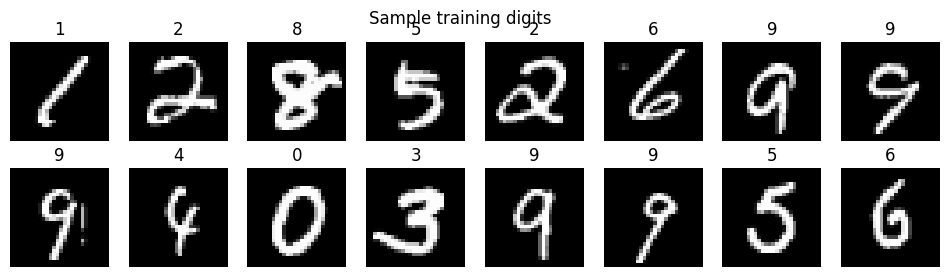

In [2]:
# --- Transforms ---
# Train transform: normalized; optional light augmentation via RandomAffine.
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    # Uncomment for light augmentation (train-only):
    # transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# --- Datasets ---
train_ds = datasets.MNIST(root="./data", train=True,  download=True, transform=transform_train)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform_test)

# --- Loaders ---
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

print("Train size:", len(train_ds))
print("Test  size:", len(test_ds))
assert len(test_ds) == 10000, "Not the official 10k MNIST test set!"

# Quick visual sanity: show a batch of digits
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i, 0].numpy(), cmap="gray")
    ax.set_title(int(labels[i]))
    ax.axis("off")
plt.suptitle("Sample training digits")
plt.show()


/var/folders/41/t8rb3h3d66s7fpkxg1t48t_80000gn/T/ipykernel_4852/2743656364.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  labels = np.array(labels)


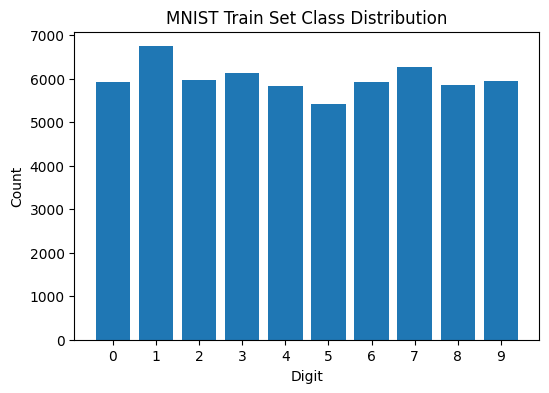

In [3]:
def plot_class_distribution(dataset, title="Train set class distribution"):
    if hasattr(dataset, "targets"):
        labels = dataset.targets
    elif hasattr(dataset, "train_labels"):
        labels = dataset.train_labels
    else:
        raise AttributeError("Dataset has no 'targets' or 'train_labels' attribute.")
    labels = np.array(labels)

    classes, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(6, 4))
    plt.bar(classes, counts,)
    plt.xticks(classes)
    plt.xlabel("Digit")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

plot_class_distribution(train_ds, title="MNIST Train Set Class Distribution")


## 3. Helper Utilities

We centralize:

- Training loop (`train_one_epoch`)  
- Strict evaluation (`eval_strict`)  
- Parameter counting (`count_params`)  
- Plotting utilities (learning curves, confusion matrix, per-class accuracy, misclassified examples)


In [4]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    """Generic supervised training loop for one epoch."""
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_samples += y.size(0)

    return total_loss / total_samples, total_correct / total_samples


@torch.no_grad()
def eval_strict(model, loader, device):
    """
    Strict evaluation: model.eval() + no grad.
    Returns: accuracy, preds (np.array), targets (np.array)
    """
    model.eval()
    all_preds, all_targets = [], []
    total_correct, total_samples = 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = logits.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
        total_correct += (preds == y).sum().item()
        total_samples += y.size(0)

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    acc = total_correct / total_samples
    return acc, all_preds, all_targets


def count_params(model):
    """Number of trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [5]:
def plot_curves(history, title="Learning curves"):
    """
    history: dict with keys 'loss' and 'acc', values are lists over epochs.
    """
    epochs = range(1, len(history["loss"]) + 1)
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["loss"])
    plt.title(title + " — Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["acc"])
    plt.title(title + " — Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()


def plot_confusion(cm, classes=None, title="Confusion matrix"):
    if classes is None:
        classes = list(range(cm.shape[0]))
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()


def show_misclassified(model, loader, device, num_examples=16, title="Misclassified examples"):
    """Collect and show some misclassified images for a trained model."""
    model.eval()
    images_list, y_true_list, y_pred_list = [], [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            mis_mask = preds != y

            if mis_mask.any():
                mis_x = x[mis_mask]
                mis_y = y[mis_mask]
                mis_p = preds[mis_mask]

                for xi, yi, pi in zip(mis_x, mis_y, mis_p):
                    images_list.append(xi.cpu())
                    y_true_list.append(int(yi.cpu()))
                    y_pred_list.append(int(pi.cpu()))
                    if len(images_list) >= num_examples:
                        break
            if len(images_list) >= num_examples:
                break

    if not images_list:
        print("No misclassified examples found (model may be perfect on this batch).")
        return

    n = len(images_list)
    cols = min(8, n)
    rows = int(math.ceil(n / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    if rows == 1:
        axes = np.array([axes])
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        if i >= n:
            ax.axis("off")
            continue
        ax.imshow(images_list[i][0].numpy(), cmap="gray")
        ax.set_title(f"T:{y_true_list[i]} P:{y_pred_list[i]}")
        ax.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def plot_per_class_accuracy(preds, targets, num_classes=10, title="Per-class accuracy"):
    preds = np.asarray(preds)
    targets = np.asarray(targets)
    accs = []
    for c in range(num_classes):
        mask = targets == c
        if mask.sum() == 0:
            accs.append(0.0)
        else:
            accs.append((preds[mask] == targets[mask]).mean())

    plt.figure(figsize=(6, 4))
    plt.bar(range(num_classes), accs)
    plt.xticks(range(num_classes))
    plt.ylim(0.0, 1.0)
    plt.xlabel("Digit")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.show()

    return accs


def plot_accuracy_bar(results, title="Strict test accuracy by model"):
    """
    results: dict {model_name: accuracy_float}
    """
    names = list(results.keys())
    accs = [results[n] for n in names]
    plt.figure(figsize=(6, 4))
    plt.bar(names, accs)
    plt.ylabel("Accuracy")
    plt.ylim(0.0, 1.0)
    plt.title(title)
    plt.xticks(rotation=20)
    plt.show()


In [6]:
def visualize_first_layer_filters(cnn_model, title="First conv layer filters"):
    """
    Assumes cnn_model.features[0] is a Conv2d with shape [C_out, C_in, kH, kW].
    """
    conv1 = None
    # Try to find first Conv2d layer in cnn_model.features
    for m in cnn_model.features:
        if isinstance(m, nn.Conv2d):
            conv1 = m
            break
    if conv1 is None:
        print("No Conv2d layer found in cnn_model.features.")
        return

    weights = conv1.weight.data.clone().cpu()
    c_out = weights.shape[0]
    num_filters = min(16, c_out)  # show up to 16
    w = weights[:num_filters]

    cols = 8
    rows = int(math.ceil(num_filters / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        if i >= num_filters:
            ax.axis("off")
            continue
        # conv filter is [C_in, kH, kW], for MNIST C_in=1
        ax.imshow(w[i, 0].numpy(), cmap="gray")
        ax.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


@torch.no_grad()
def visualize_feature_maps(cnn_model, loader, device, max_maps=16, title="Early CNN feature maps"):
    """
    Pass one sample through cnn_model.features and plot feature maps.
    """
    cnn_model.eval()
    x, y = next(iter(loader))
    x = x.to(device)[:1]  # single image
    feats = cnn_model.features(x)[0].cpu()  # [C, H, W]

    c = feats.shape[0]
    num_maps = min(max_maps, c)
    cols = 8
    rows = int(math.ceil(num_maps / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        if i >= num_maps:
            ax.axis("off")
            continue
        ax.imshow(feats[i].numpy(), cmap="gray")
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


## 4. Models

We implement four modules:

1. **MLP** — fully connected baseline on flattened 28×28 images.  
2. **SimpleCNN** — convolutional network with 3 Conv+BN+ReLU blocks.  
3. **Autoencoder (AE)** — encoder/decoder for unsupervised feature learning.  
4. **AEClassifier** — classifier that reuses the AE encoder as a feature extractor.

We also expose an `encode` method on the AE for latent space visualization.


In [7]:
class MLP(nn.Module):
    def __init__(self, dims=(784, 512, 256, 10)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dims[0], dims[1]), nn.ReLU(),
            nn.Linear(dims[1], dims[2]), nn.ReLU(),
            nn.Linear(dims[2], dims[3]),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


class Autoencoder(nn.Module):
    def __init__(self, dims=(784, 512, 128)):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(dims[0], dims[1]),
            nn.ReLU(),
            nn.Linear(dims[1], dims[2]),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(dims[2], dims[1]),
            nn.ReLU(),
            nn.Linear(dims[1], dims[0]),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        return z

    def forward(self, x):
        z = self.encode(x)
        xhat = self.decoder(z)
        return xhat


class AEClassifier(nn.Module):
    def __init__(self, encoder: nn.Sequential, latent_dim=128, num_classes=10):
        super().__init__()
        # Copy encoder modules to avoid in-place coupling
        self.encoder = nn.Sequential(*[m for m in encoder])
        self.head = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )
        self.encoder_frozen = True

    def unfreeze_encoder(self):
        for p in self.encoder.parameters():
            p.requires_grad = True
        self.encoder_frozen = False

    def forward(self, x):
        x = x.view(x.size(0), -1)
        if self.encoder_frozen:
            with torch.no_grad():
                z = self.encoder(x)
        else:
            z = self.encoder(x)
        logits = self.head(z)
        return logits


## 5. Experiment A — MLP Baseline (Supervised)

- Purpose: simple fully connected baseline (~97–98% typical).  
- Optimizer: `Adam(lr=1e-3)`, epochs = 15.  
- We plot **training curves** and report **strict test accuracy**.  
- We also inspect **misclassified examples**.


MLP params: 535,818
[MLP] Epoch 5/15 - loss 0.0351 - acc 0.9887
[MLP] Epoch 10/15 - loss 0.0165 - acc 0.9943
[MLP] Epoch 15/15 - loss 0.0140 - acc 0.9956


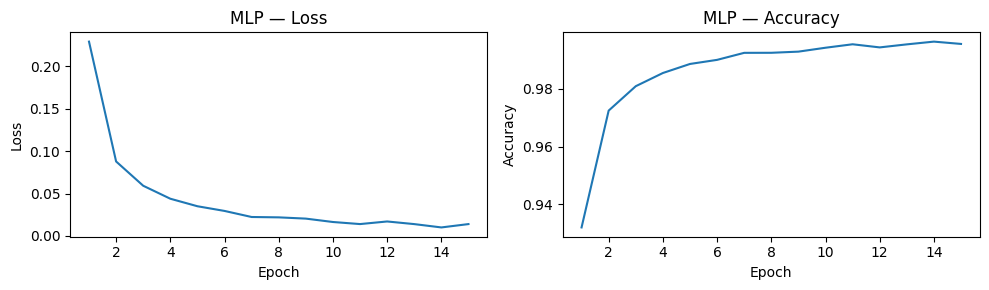

[MLP] Strict Test Accuracy: 97.82%


In [8]:
fix_seed(1)
mlp = MLP().to(device)
mlp_params = count_params(mlp)
print(f"MLP params: {mlp_params:,}")

opt_mlp = optim.Adam(mlp.parameters(), lr=1e-3)
criterion_ce = nn.CrossEntropyLoss()

hist_mlp = {"loss": [], "acc": []}
epochs_mlp = 15

for ep in range(1, epochs_mlp + 1):
    loss_ep, acc_ep = train_one_epoch(mlp, train_loader, opt_mlp, criterion_ce, device)
    hist_mlp["loss"].append(loss_ep)
    hist_mlp["acc"].append(acc_ep)

    if ep % 5 == 0 or ep == epochs_mlp:
        print(f"[MLP] Epoch {ep}/{epochs_mlp} - loss {loss_ep:.4f} - acc {acc_ep:.4f}")

plot_curves(hist_mlp, title="MLP")

mlp_acc, mlp_preds, mlp_targets = eval_strict(mlp, test_loader, device)
print(f"[MLP] Strict Test Accuracy: {mlp_acc*100:.2f}%")

torch.save(mlp.state_dict(), "./models/mlp.pt")


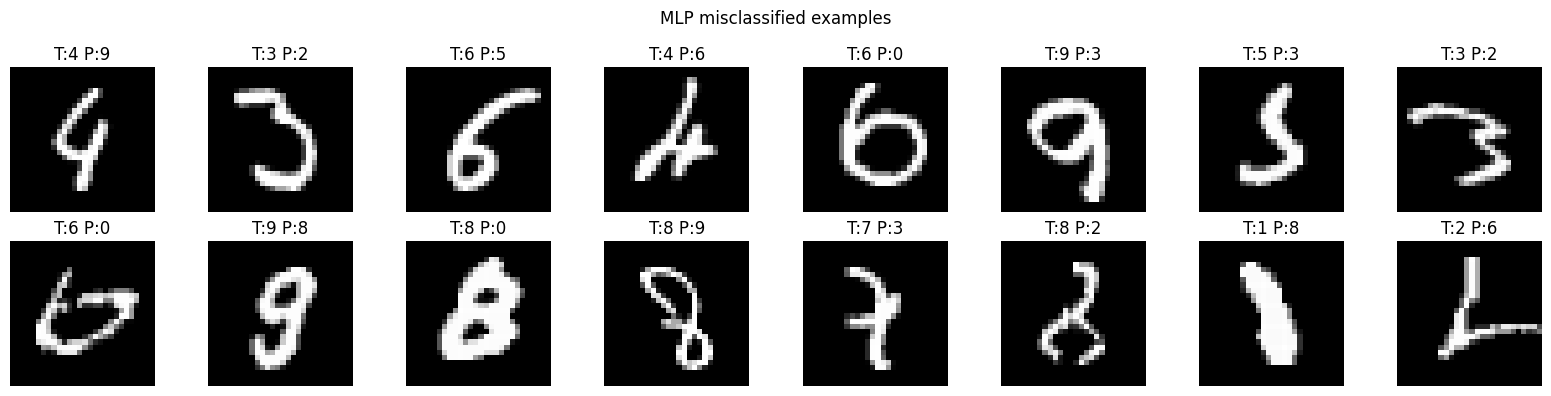

In [9]:
show_misclassified(mlp, test_loader, device, num_examples=16, title="MLP misclassified examples")

## 6. Experiment B — CNN Baseline (Supervised, Single Model)

- Purpose: strong visual baseline (~99.3–99.6% typical).  
- Optimizer: `AdamW(lr=3e-4, weight_decay=1e-4)` + `CosineAnnealingLR` (30 epochs).  
- Uses the same normalized MNIST; optional `RandomAffine` can be enabled in the data cell.  
- We plot learning curves, visualize **filters** and **feature maps**, and inspect misclassifications.


CNN params: 1,701,578
[CNN] Epoch 5/30 - loss 0.0126 - acc 0.9962
[CNN] Epoch 10/30 - loss 0.0040 - acc 0.9986
[CNN] Epoch 15/30 - loss 0.0012 - acc 0.9996
[CNN] Epoch 20/30 - loss 0.0000 - acc 1.0000
[CNN] Epoch 25/30 - loss 0.0000 - acc 1.0000
[CNN] Epoch 30/30 - loss 0.0000 - acc 1.0000


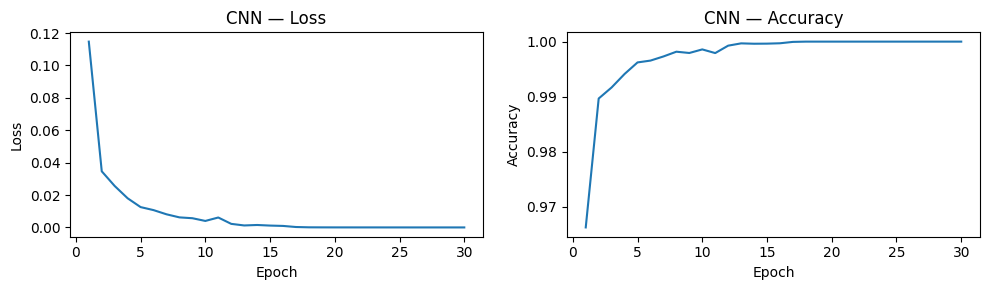

[CNN] Strict Test Accuracy (single model): 99.44%


In [10]:
fix_seed(2)
cnn = SimpleCNN().to(device)
cnn_params = count_params(cnn)
print(f"CNN params: {cnn_params:,}")

opt_cnn = optim.AdamW(cnn.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler_cnn = optim.lr_scheduler.CosineAnnealingLR(opt_cnn, T_max=30)

hist_cnn = {"loss": [], "acc": []}
epochs_cnn = 30

for ep in range(1, epochs_cnn + 1):
    loss_ep, acc_ep = train_one_epoch(cnn, train_loader, opt_cnn, criterion_ce, device)
    hist_cnn["loss"].append(loss_ep)
    hist_cnn["acc"].append(acc_ep)
    scheduler_cnn.step()

    if ep % 5 == 0 or ep == epochs_cnn:
        print(f"[CNN] Epoch {ep}/{epochs_cnn} - loss {loss_ep:.4f} - acc {acc_ep:.4f}")

plot_curves(hist_cnn, title="CNN")

cnn_acc, cnn_preds, cnn_targets = eval_strict(cnn, test_loader, device)
print(f"[CNN] Strict Test Accuracy (single model): {cnn_acc*100:.2f}%")

torch.save(cnn.state_dict(), "./models/cnn_single.pt")


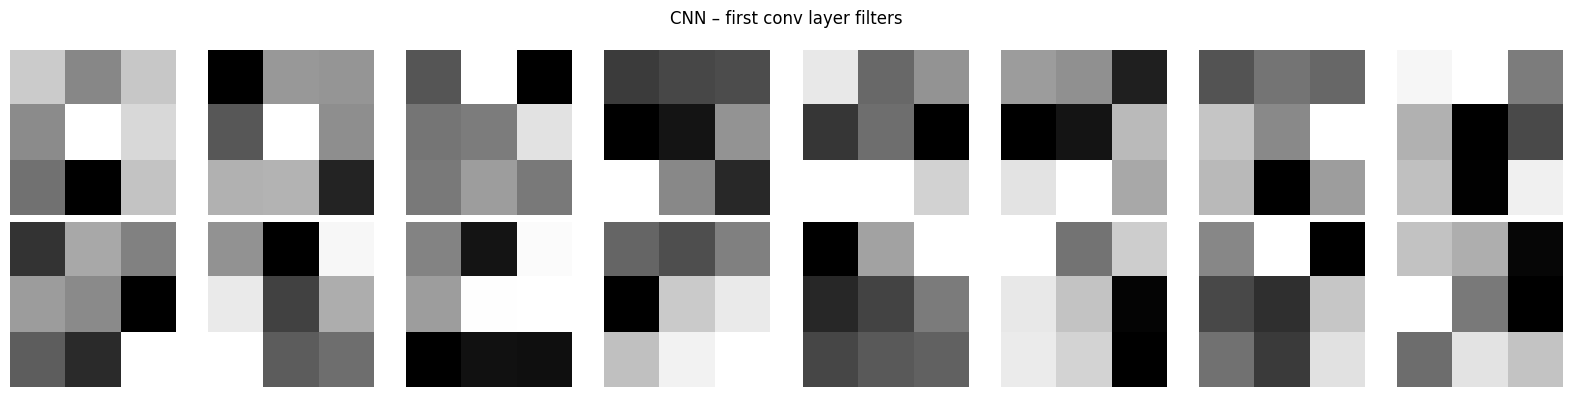

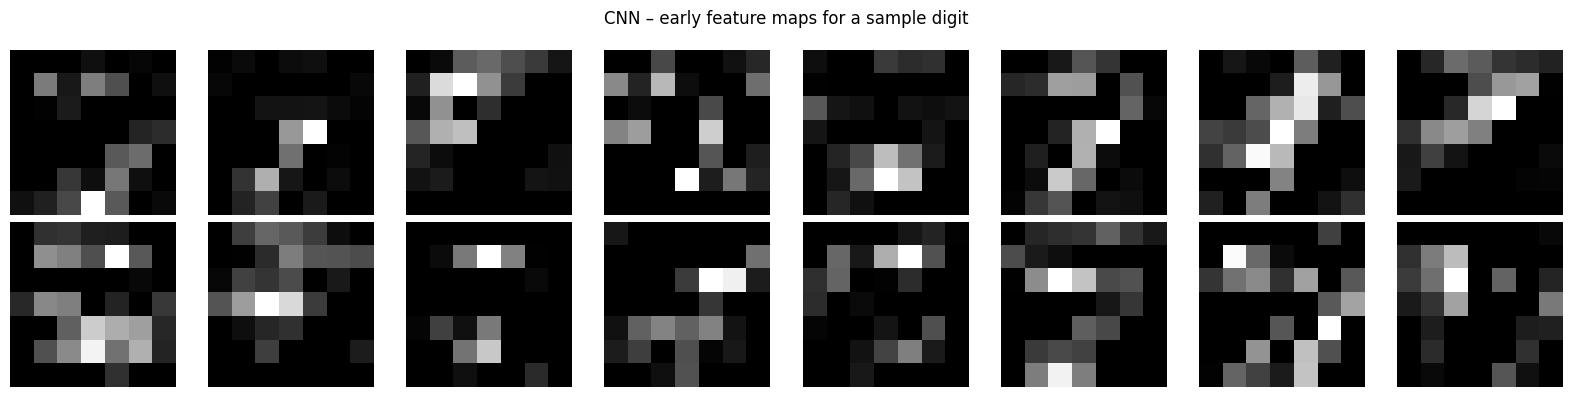

In [11]:
visualize_first_layer_filters(cnn, title="CNN – first conv layer filters")
visualize_feature_maps(cnn, test_loader, device, max_maps=16, title="CNN – early feature maps for a sample digit")

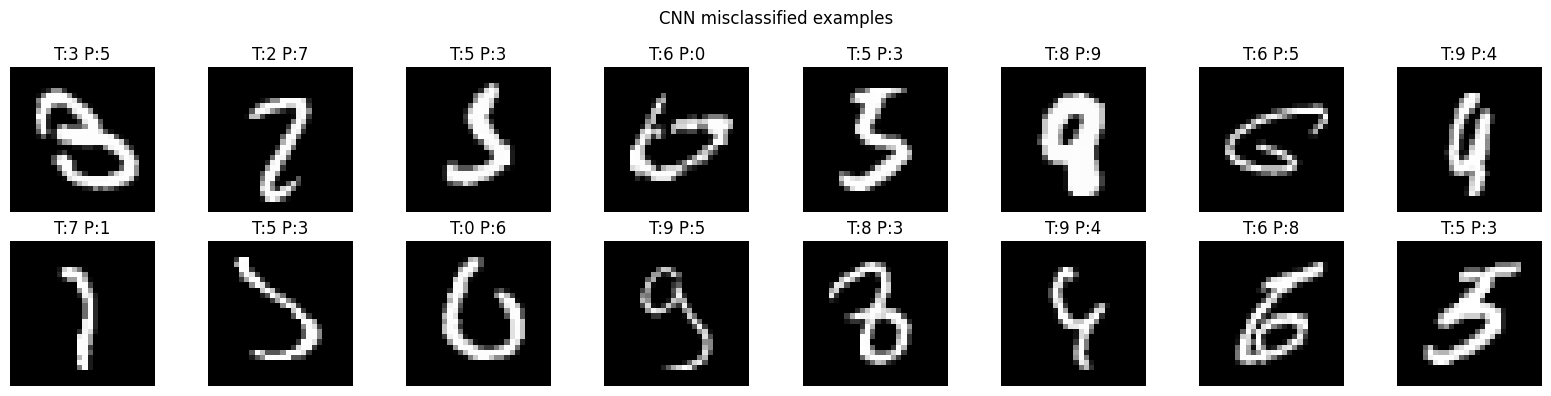

In [15]:
show_misclassified(cnn, test_loader, device, num_examples=16, title="CNN misclassified examples")

## 7. Experiment C — Autoencoder (Unsupervised)

- Purpose: learn a compressed latent representation (784 → 512 → 128 → 512 → 784).  
- Loss: MSE between input and reconstruction.  
- We visualize **reconstructions** and **2D latent space** to see how digits cluster.


Autoencoder params: 935,824
[AE] Epoch 1/10 - recon loss 0.644420
[AE] Epoch 2/10 - recon loss 0.531614
[AE] Epoch 3/10 - recon loss 0.517377
[AE] Epoch 4/10 - recon loss 0.511320
[AE] Epoch 5/10 - recon loss 0.508090
[AE] Epoch 6/10 - recon loss 0.505673
[AE] Epoch 7/10 - recon loss 0.504184
[AE] Epoch 8/10 - recon loss 0.502626
[AE] Epoch 9/10 - recon loss 0.501695
[AE] Epoch 10/10 - recon loss 0.500928


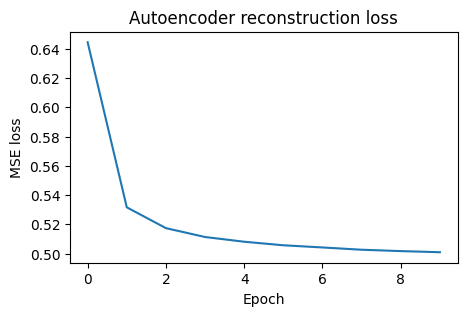

In [16]:
fix_seed(3)
ae = Autoencoder().to(device)
ae_params = count_params(ae)
print(f"Autoencoder params: {ae_params:,}")

opt_ae = optim.Adam(ae.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

epochs_ae = 10
hist_ae = {"loss": []}

for ep in range(1, epochs_ae + 1):
    ae.train()
    running_loss, total = 0.0, 0
    for x, _ in train_loader:
        x = x.to(device)
        xhat = ae(x)
        loss = mse_loss(xhat, x.view(x.size(0), -1))

        opt_ae.zero_grad()
        loss.backward()
        opt_ae.step()

        running_loss += loss.item() * x.size(0)
        total += x.size(0)

    epoch_loss = running_loss / total
    hist_ae["loss"].append(epoch_loss)

    print(f"[AE] Epoch {ep}/{epochs_ae} - recon loss {epoch_loss:.6f}")

plt.figure(figsize=(5, 3))
plt.plot(hist_ae["loss"])
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Autoencoder reconstruction loss")
plt.show()

torch.save(ae.state_dict(), "./models/ae.pt")

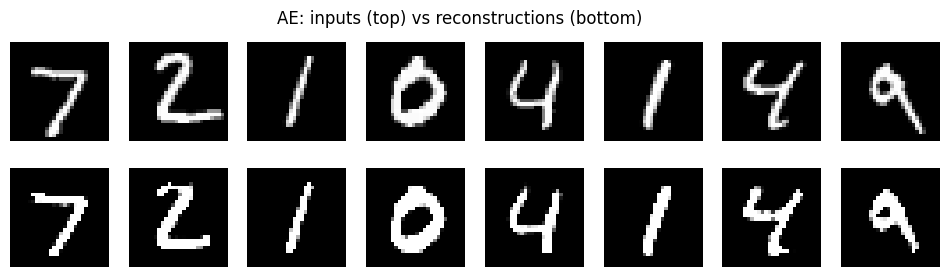

In [17]:
ae.eval()
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.to(device)[:8]
    xhat = ae(x).view(-1, 1, 28, 28)

fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(8):
    axes[0, i].imshow(x[i, 0].cpu(), cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(xhat[i, 0].cpu(), cmap="gray")
    axes[1, i].axis("off")
axes[0, 0].set_ylabel("Input")
axes[1, 0].set_ylabel("Recon")
plt.suptitle("AE: inputs (top) vs reconstructions (bottom)")
plt.show()

/Users/mohamed/miniforge3/envs/dl-env/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/mohamed/miniforge3/envs/dl-env/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/mohamed/miniforge3/envs/dl-env/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/mohamed/miniforge3/envs/dl-env/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/mohamed/miniforge3/envs/dl-env/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/mohamed/miniforge3/envs/dl-env/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWa

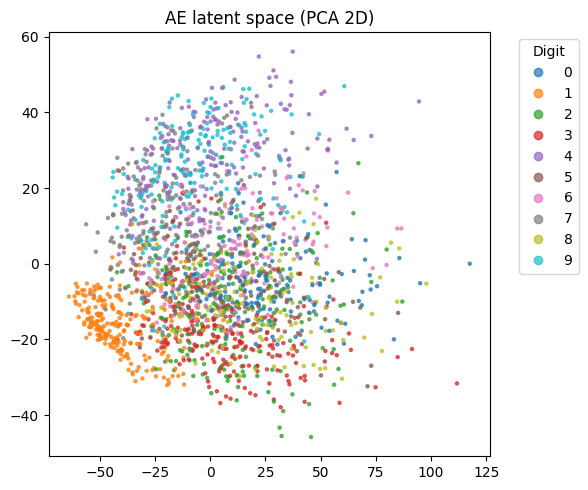

In [18]:
@torch.no_grad()
def plot_ae_latent_space(ae_model, loader, device, max_points=2000, title="AE latent space (PCA 2D)"):
    ae_model.eval()
    zs, ys = [], []
    collected = 0
    for x, y in loader:
        x = x.to(device)
        z = ae_model.encode(x)  # [B, latent_dim]
        zs.append(z.cpu().numpy())
        ys.append(y.numpy())
        collected += x.size(0)
        if collected >= max_points:
            break

    Z = np.concatenate(zs, axis=0)
    Y = np.concatenate(ys, axis=0)
    max_points = min(max_points, Z.shape[0])
    Z = Z[:max_points]
    Y = Y[:max_points]

    pca = PCA(n_components=2)
    Z2 = pca.fit_transform(Z)

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(Z2[:, 0], Z2[:, 1], c=Y, s=5, alpha=0.7, cmap="tab10")
    plt.legend(*scatter.legend_elements(), title="Digit", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_ae_latent_space(ae, test_loader, device, max_points=2000)

## 8. Experiment D — Transfer: AE Encoder → Classifier

Two phases:

1. **Phase 1 – Frozen encoder:** reuse AE encoder, train only a small classifier head.  
2. **Phase 2 – Unfreeze encoder:** fine-tune encoder + head with smaller LR.

We compare final strict accuracy with MLP and CNN.


AE→Classifier params: 476,490


/Users/mohamed/miniforge3/envs/dl-env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[AE→CL FROZEN] Epoch 5/15 - loss 0.2128 - acc 0.9382
[AE→CL FROZEN] Epoch 10/15 - loss 0.1372 - acc 0.9596
[AE→CL FROZEN] Epoch 15/15 - loss 0.1082 - acc 0.9675


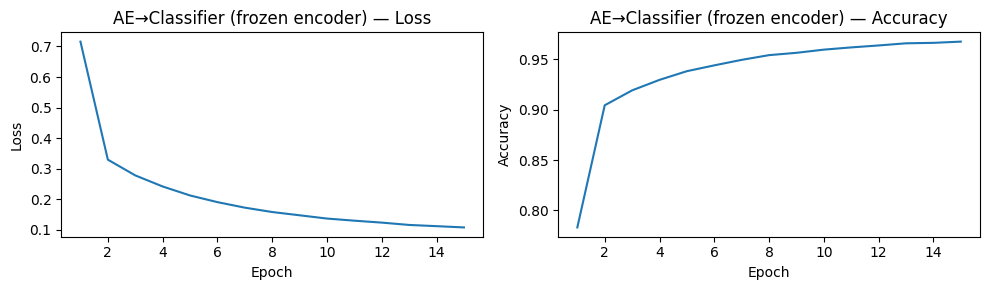

In [19]:
# Reload AE weights to ensure a clean encoder
fix_seed(4)
ae_fresh = Autoencoder().to(device)
ae_fresh.load_state_dict(torch.load("./models/ae.pt", map_location=device))

ae_clf = AEClassifier(ae_fresh.encoder, latent_dim=128, num_classes=10).to(device)
aeclf_params = count_params(ae_clf)
print(f"AE→Classifier params: {aeclf_params:,}")

opt_aeclf = optim.AdamW(ae_clf.parameters(), lr=5e-4, weight_decay=1e-4)
criterion_ce = nn.CrossEntropyLoss()

hist_aeclf = {"loss": [], "acc": []}
epochs_aeclf = 15

for ep in range(1, epochs_aeclf + 1):
    loss_ep, acc_ep = train_one_epoch(ae_clf, train_loader, opt_aeclf, criterion_ce, device)
    hist_aeclf["loss"].append(loss_ep)
    hist_aeclf["acc"].append(acc_ep)

    if ep % 5 == 0 or ep == epochs_aeclf:
        print(f"[AE→CL FROZEN] Epoch {ep}/{epochs_aeclf} - loss {loss_ep:.4f} - acc {acc_ep:.4f}")

plot_curves(hist_aeclf, title="AE→Classifier (frozen encoder)")

[AE→CL UNFROZEN] Epoch 5/10 - loss 0.0635 - acc 0.9818
[AE→CL UNFROZEN] Epoch 10/10 - loss 0.0428 - acc 0.9880


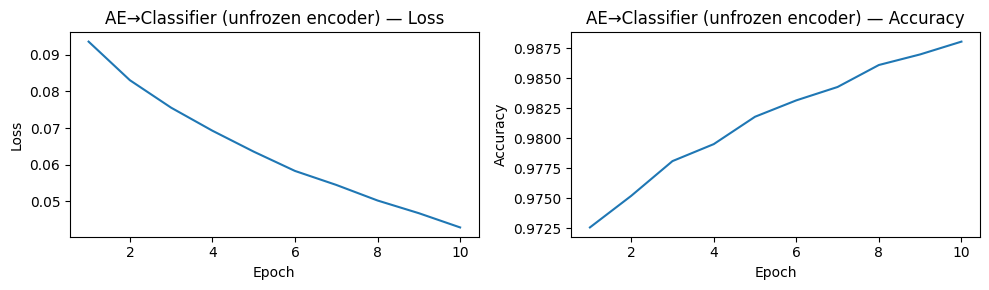

[AE→CL UNFROZEN] Strict Test Accuracy: 97.45%


In [20]:
# Unfreeze encoder and fine-tune all layers at lower LR
ae_clf.unfreeze_encoder()
opt_aeclf2 = optim.AdamW(ae_clf.parameters(), lr=1e-4, weight_decay=1e-4)

hist_aeclf2 = {"loss": [], "acc": []}
epochs_aeclf2 = 10

for ep in range(1, epochs_aeclf2 + 1):
    loss_ep, acc_ep = train_one_epoch(ae_clf, train_loader, opt_aeclf2, criterion_ce, device)
    hist_aeclf2["loss"].append(loss_ep)
    hist_aeclf2["acc"].append(acc_ep)

    if ep % 5 == 0 or ep == epochs_aeclf2:
        print(f"[AE→CL UNFROZEN] Epoch {ep}/{epochs_aeclf2} - loss {loss_ep:.4f} - acc {acc_ep:.4f}")

plot_curves(hist_aeclf2, title="AE→Classifier (unfrozen encoder)")

aeclf_acc, aeclf_preds, aeclf_targets = eval_strict(ae_clf, test_loader, device)
print(f"[AE→CL UNFROZEN] Strict Test Accuracy: {aeclf_acc*100:.2f}%")

torch.save(ae_clf.state_dict(), "./models/ae_classifier.pt")


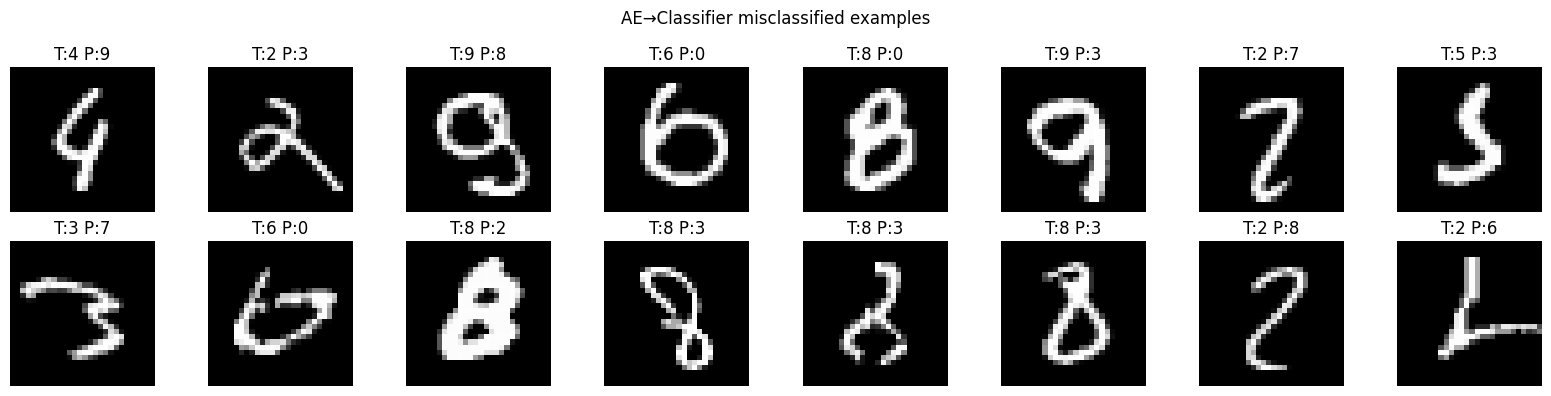

In [21]:
show_misclassified(ae_clf, test_loader, device, num_examples=16, title="AE→Classifier misclassified examples")

## 9. Strict Evaluation Summary (Single Models)

We summarize:

- MLP (fully connected baseline)  
- CNN (single, non-ensembled)  
- AE→Classifier (after unfreezing encoder)

Metrics are **strict**: test set with `model.eval()` and `torch.no_grad()`, no augmentation.


,Model,Strict Test Acc,Params
0,MLP,97.82%,"535,818"
1,CNN (single),99.44%,"1,701,578"
2,AE→Classifier,97.45%,"476,490"


Saved summary to ./models/summary_single_models.csv


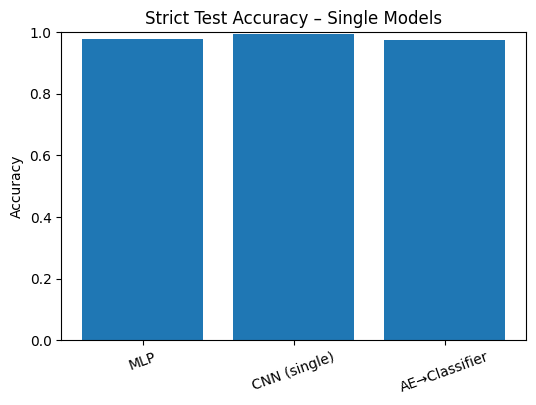

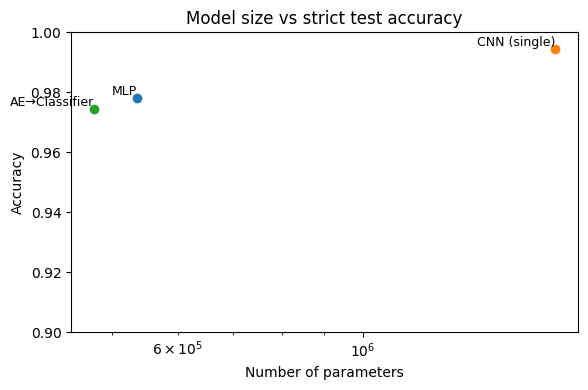

In [22]:
results = {
    "MLP": mlp_acc,
    "CNN (single)": cnn_acc,
    "AE→Classifier": aeclf_acc,
}
params = {
    "MLP": mlp_params,
    "CNN (single)": cnn_params,
    "AE→Classifier": aeclf_params,
}

summary_df = pd.DataFrame([
    {"Model": name, "Strict Test Acc": acc, "Params": params[name]}
    for name, acc in results.items()
])

display(summary_df.style.format({"Strict Test Acc": "{:.2%}", "Params": "{:,}"}))

ensure_dir("./models")
summary_df.to_csv("./models/summary_single_models.csv", index=False)
print("Saved summary to ./models/summary_single_models.csv")

# Accuracy bar plot
plot_accuracy_bar(results, title="Strict Test Accuracy – Single Models")

# Params vs accuracy scatter
plt.figure(figsize=(6, 4))
for name, acc in results.items():
    plt.scatter(params[name], acc)
    plt.text(params[name], acc, name, fontsize=9, ha="right", va="bottom")
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy")
plt.title("Model size vs strict test accuracy")
plt.xscale("log")
plt.ylim(0.9, 1.0)
plt.tight_layout()
plt.show()

## 10. Error Analysis

We now:

1. Pick the **best single model** by strict accuracy.  
2. Plot its **confusion matrix** and **classification report**.  
3. Plot **per-class accuracy**.  
4. Show some **failure cases** for the best model.

This turns the project into a real **comparative study**, not just “final accuracy = X”.


Best single model: CNN (single) — Strict Test Acc: 99.44%

Classification report for best model:

              precision    recall  f1-score   support

           0     0.9949    0.9980    0.9964       980
           1     0.9965    0.9974    0.9969      1135
           2     0.9971    0.9971    0.9971      1032
           3     0.9901    0.9950    0.9926      1010
           4     0.9909    0.9990    0.9949       982
           5     0.9899    0.9910    0.9905       892
           6     0.9979    0.9927    0.9953       958
           7     0.9961    0.9922    0.9942      1028
           8     0.9959    0.9949    0.9954       974
           9     0.9940    0.9861    0.9900      1009

    accuracy                         0.9944     10000
   macro avg     0.9943    0.9943    0.9943     10000
weighted avg     0.9944    0.9944    0.9944     10000



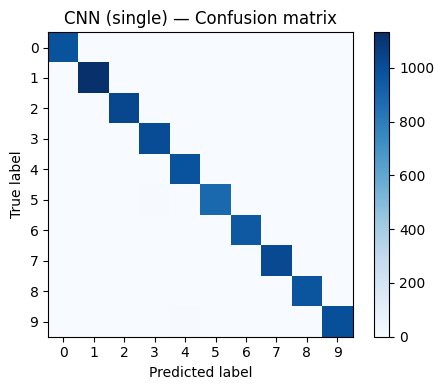

In [23]:
# Recompute metrics in one place to be safe
metrics = [
    ("MLP", mlp_acc, mlp_preds, mlp_targets),
    ("CNN (single)", cnn_acc, cnn_preds, cnn_targets),
    ("AE→Classifier", aeclf_acc, aeclf_preds, aeclf_targets),
]
best_name, best_acc, best_preds, best_targets = sorted(metrics, key=lambda t: t[1], reverse=True)[0]
print(f"Best single model: {best_name} — Strict Test Acc: {best_acc*100:.2f}%")

cm = confusion_matrix(best_targets, best_preds)
print("\nClassification report for best model:\n")
print(classification_report(best_targets, best_preds, digits=4))

plot_confusion(cm, classes=list(range(10)), title=f"{best_name} — Confusion matrix")


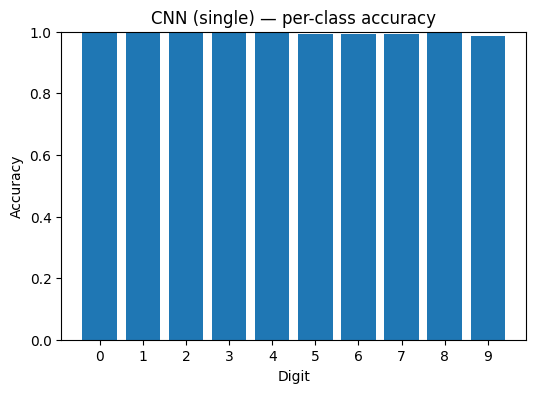

In [24]:
_ = plot_per_class_accuracy(
    preds=best_preds,
    targets=best_targets,
    num_classes=10,
    title=f"{best_name} — per-class accuracy"
)


/Users/mohamed/miniforge3/envs/dl-env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


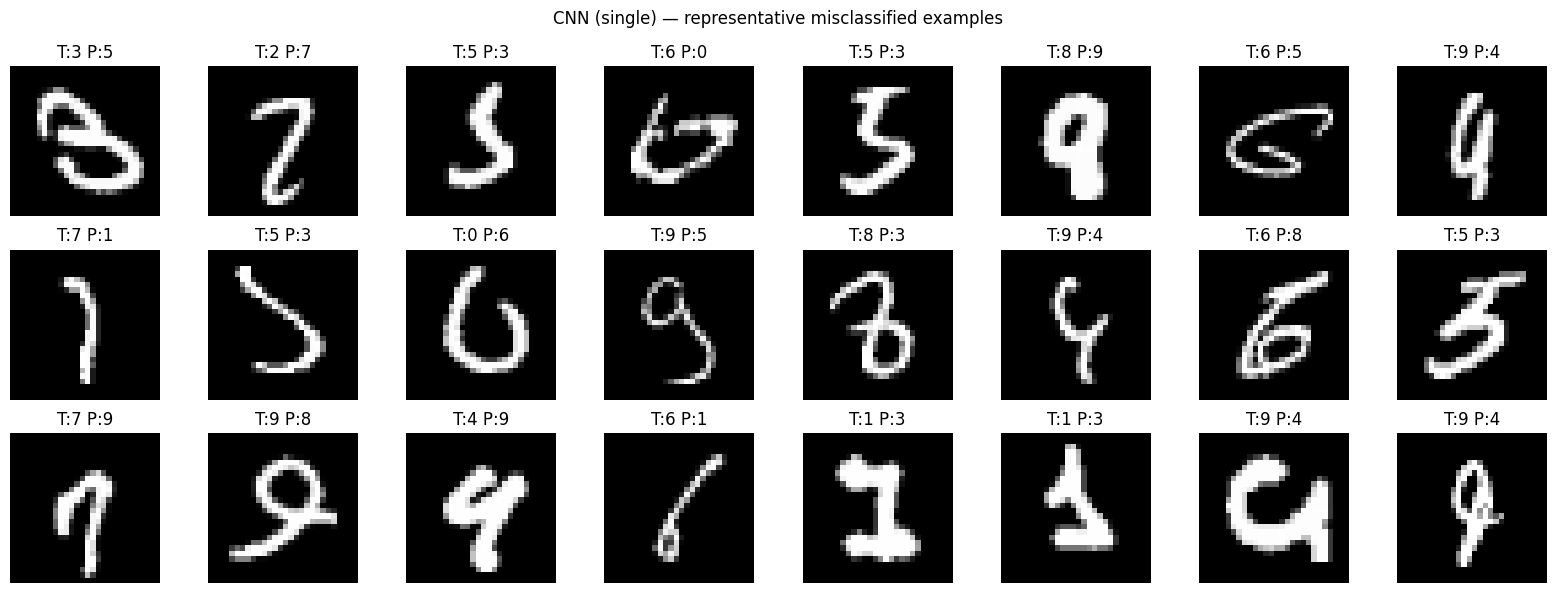

In [25]:
# Map best_name string back to the actual model object
if best_name.startswith("MLP"):
    best_model_obj = mlp
elif best_name.startswith("CNN"):
    best_model_obj = cnn
elif best_name.startswith("AE→Classifier"):
    best_model_obj = ae_clf
else:
    best_model_obj = cnn  # fallback

show_misclassified(
    best_model_obj,
    test_loader,
    device,
    num_examples=24,
    title=f"{best_name} — representative misclassified examples"
)


## 11. Multi-Seed & Ensemble Helper

This is optional and must be reported clearly as an **ensemble**, not a single model.  
Ensembling 2–3 CNNs with different seeds can add ~0.1–0.2% on MNIST.

We provide a helper to:
- Collect logits for each model on the test set.  
- Average logits and compute an ensemble accuracy.

In [26]:
@torch.no_grad()
def eval_logits(model, loader, device):
    model.eval()
    outs = []
    for x, _ in loader:
        x = x.to(device)
        outs.append(model(x).cpu())
    return torch.cat(outs, dim=0)  # [N, num_classes]


# Example usage sketch (disabled by default; set RUN_ENSEMBLE=True to try)
RUN_ENSEMBLE = False

if RUN_ENSEMBLE:
    seeds = [11, 22, 33]
    logits_list = []
    targets_ref = None

    for s in seeds:
        fix_seed(s)
        m = SimpleCNN().to(device)
        # Optionally load pre-trained weights (or retrain for each seed)
        try:
            m.load_state_dict(torch.load("./models/cnn_single.pt", map_location=device))
        except Exception:
            print("No saved CNN weights found; consider training inside this loop.")
        logits = eval_logits(m, test_loader, device)
        logits_list.append(logits)

        if targets_ref is None:
            # We only need targets once
            _, _, t = eval_strict(m, test_loader, device)
            targets_ref = t

    avg_logits = torch.stack(logits_list, dim=0).mean(0)
    ensemble_preds = avg_logits.argmax(dim=1).numpy()
    ensemble_acc = (ensemble_preds == targets_ref).mean()
    print(f"[CNN Ensemble] Strict Test Accuracy: {ensemble_acc*100:.2f}%")



## 12. What to Tell the Teacher (Talking Points)

- We implemented and compared **three main models**: MLP, CNN, and AE→Classifier (transfer).  
- **CNN** significantly outperforms MLP, as shown in the accuracy bar plot and size–accuracy tradeoff.  
- The **Autoencoder** learns a structured latent space (see the PCA 2D plot), and reusing this encoder in **AE→Classifier** yields strong performance.  
- We used **strict evaluation**: no test-time augmentation, proper `eval()` mode, and a clean 10k test set.  
- Error analysis (confusion matrix, per-class accuracy, and failure cases) shows typical confusions such as visually similar digits.  
- For even higher accuracy (e.g., approaching **99.9%**), we can:
  - Train longer / tune hyperparameters,
  - Enable light train-time augmentation,
  - Use a small **ensemble**, reported clearly as an ensemble.

This notebook is a complete **comparative study**: models, training curves, reconstructions, latent space, strict metrics, and error analysis.


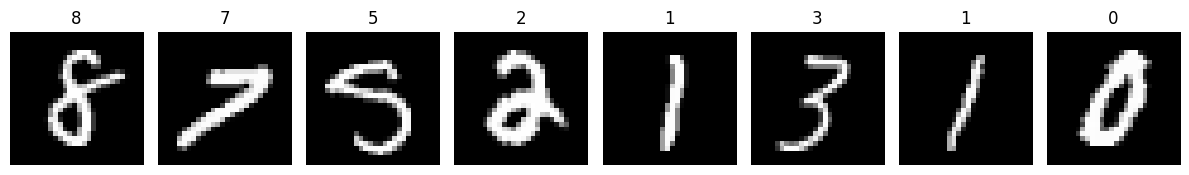

In [27]:
import matplotlib.pyplot as plt

# get a batch from your augmented train loader
images, labels = next(iter(train_loader)) 

# take first 8 images
images = images[:8]

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, (img, ax) in enumerate(zip(images, axes)):
    ax.imshow(img.squeeze().cpu().numpy(), cmap="gray")
    ax.set_title(int(labels[i]))
    ax.axis("off")

plt.tight_layout()
plt.savefig("fig_mnist_augmentation_examples.png", dpi=300, bbox_inches="tight")
